# Sign Language Image Classification with Vision Transformers

### Dataset Preprocessing  for Vision Transformer (ViT) Model

### **Load Dataset**
   - The dataset is loaded using Keras's `image_dataset_from_directory` function.
   - Images are resized to 224x224 to match the input size of the ViT model.

### **Model and Feature Extractor Loading**:
   - The Vision Transformer model `vit-tiny-patch16` is loaded from the `transformers` library.
   - The corresponding feature extractor is also loaded to preprocess images for the model.

### **Preprocessing**:
   - A `preprocess_vit` function applies the feature extractor transformations to normalize and prepare images for the ViT model.
   - The dataset is mapped to this preprocessing function with parallelization for improved performance.

### **Dataset Splitting**:
   - The dataset is split into training (70%), validation (10%), and testing (20%) subsets.


### Install packages

### Import packages

In [ ]:
import os

# Set up dataset path and name
kaggle_dataset = "kapillondhe/american-sign-language"
dataset_dir = "./sign-language-dataset"  # Path to store the dataset

# Ensure the dataset directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print("Downloading dataset from Kaggle...")

    # Download and unzip the dataset
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_dir} --unzip")
    print("Dataset downloaded and unzipped.")
else:
    print("Dataset already downloaded.")


In [ ]:
import os

dataset_dir = "./sign-language-dataset"

if os.path.exists(dataset_dir):
    print("Dataset directory exists.")
    print("Contents:", os.listdir(dataset_dir))
else:
    print("Dataset directory not found.")


In [ ]:
import os

dataset_path = "./sign-language-dataset/ASL_Dataset"
print("Contents of ASL_Dataset:", os.listdir(dataset_path))


In [2]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


c:\Users\myrto\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Load dataset

In [5]:
from datasets import load_dataset


# Specify the correct paths based on the Kaggle dataset directory
# dataset_dir = "./sign-language-dataset/ASL_Dataset"  # Path where the dataset is stored
# train_dataset_path = f"{dataset_dir}/Train"
# test_dataset_path = f"{dataset_dir}/Test"
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train"
test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Test"
# Load the train and test datasets separately using `imagefolder` format
train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)


Computing checksums: 100%|██████████| 165670/165670 [01:24<00:00, 1968.51it/s]
Generating train split: 165670 examples [00:09, 16999.03 examples/s]
Generating train split: 112 examples [00:00, 9522.85 examples/s]

Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 165670
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 112
    })
})


In [6]:
import os
import pickle
from datasets import load_dataset

# Specify dataset paths
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train"
test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Test"

# Cache filenames for train and test datasets
train_cache_file = "ASL_train_dataset_cache.pkl"
test_cache_file = "ASL_test_dataset_cache.pkl"

# Load train dataset from cache or source
if os.path.exists(train_cache_file):
    print("Loading train dataset from cache...")
    with open(train_cache_file, "rb") as f:
        train_dataset = pickle.load(f)
else:
    print("Loading train dataset from source and caching it...")
    train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
    with open(train_cache_file, "wb") as f:
        pickle.dump(train_dataset, f)

# Load test dataset from cache or source
if os.path.exists(test_cache_file):
    print("Loading test dataset from cache...")
    with open(test_cache_file, "rb") as f:
        test_dataset = pickle.load(f)
else:
    print("Loading test dataset from source and caching it...")
    test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)
    with open(test_cache_file, "wb") as f:
        pickle.dump(test_dataset, f)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Loading train dataset from source and caching it...
Loading test dataset from source and caching it...
Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 165670
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 112
    })
})


In [1]:
from PIL import Image

import os
from PIL import Image

# Corrected file path based on your message
file_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\ASL_Dataset\Train\A\5.jpg"

# Check if the file exists
if os.path.exists(file_path):
    # Open the image if it exists
    img = Image.open(file_path)
    print(f"Image dimensions: {img.size}")
else:
    print(f"File not found: {file_path}")




Image dimensions: (400, 400)


In [ ]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std


In [ ]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']  # Access image from the dataset
        label = self.dataset[idx]['label']  # Access label from the dataset
        if self.transform:
            image = self.transform(image)  # Apply transformation to the image
        return image, label

In [ ]:
train_split = train_dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


In [ ]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [ ]:
# num_classes = calculate_num_classes(train_dataset['train'])


In [ ]:
# print(f"Number of classes in the dataset: {num_classes}")

In [7]:
# mean, std = calculate_mean_std(dataset['train'])
mean = [0.5616, 0.5301, 0.5136]
std = [0.1045, 0.1655, 0.1861]
num_classes = 28

In [ ]:
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

In [8]:
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder 
# Now, apply the normalization step after calculating mean and std
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with calculated mean and std
])

# Apply transformation to datasets
train_dataset = ImageFolder(root=train_dataset_path, transform=transform_norm)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform_norm)

# Now, split the training dataset into train and validation
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
for images, labels in train_loader_resized:
    print(images.shape)  # Should print [64, 3, 224, 224]
    break  # Just to check one batch

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot class distribution with enhanced visualization
def plot_class_distribution(dataset, title):
    # Count occurrences of each class
    class_counts = Counter([dataset[i][1] for i in range(len(dataset))])
    
    # Sort class labels and counts
    labels, counts = zip(*sorted(class_counts.items()))
    
    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 6))  # Set figure size (adjust as needed)
    
    # Plot the distribution
    plt.bar(labels, counts, tick_label=[str(label) for label in labels], color='skyblue')
    plt.xlabel('Class Labels', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.title(title, fontsize=16)
    
    # Rotate tick labels for better readability if there are many classes
    plt.xticks( fontsize=12)
    
    # Increase the size of the y-axis labels and ticks for better visibility
    plt.yticks(fontsize=12)
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()




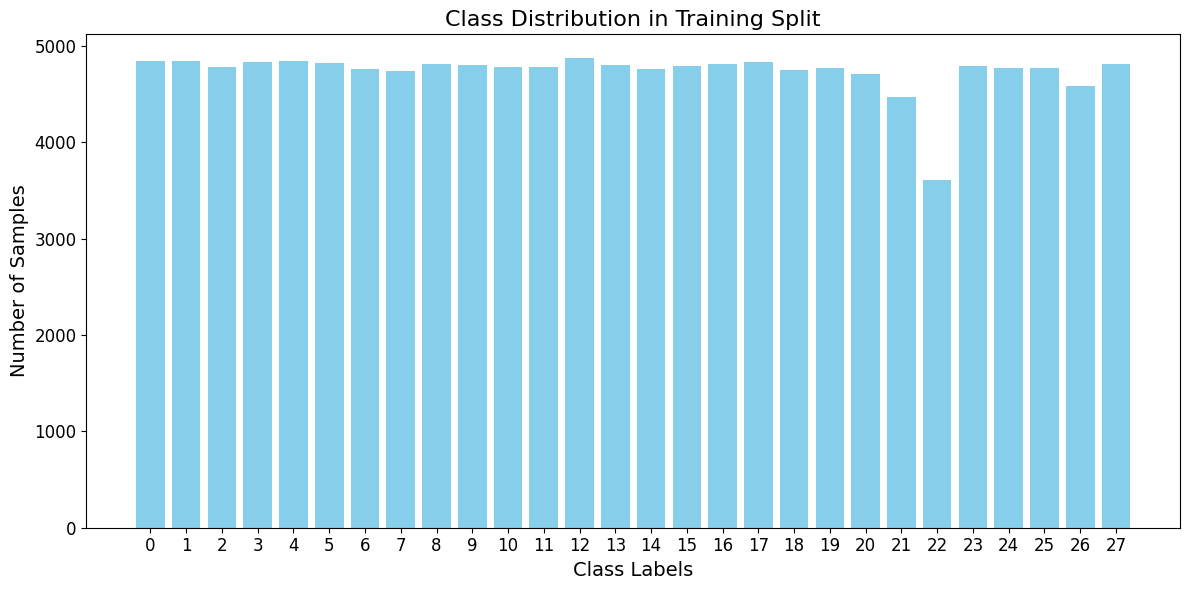

In [10]:
plot_class_distribution(train_split, "Class Distribution in Training Split")

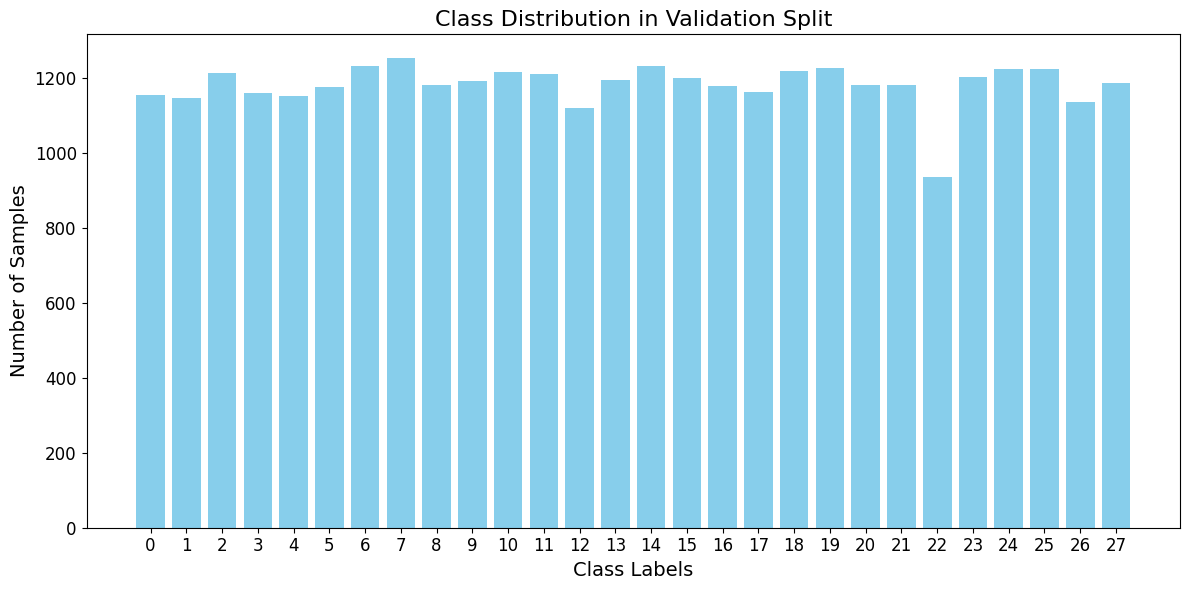

In [11]:
# Plot for validation split
plot_class_distribution(val_split, "Class Distribution in Validation Split")

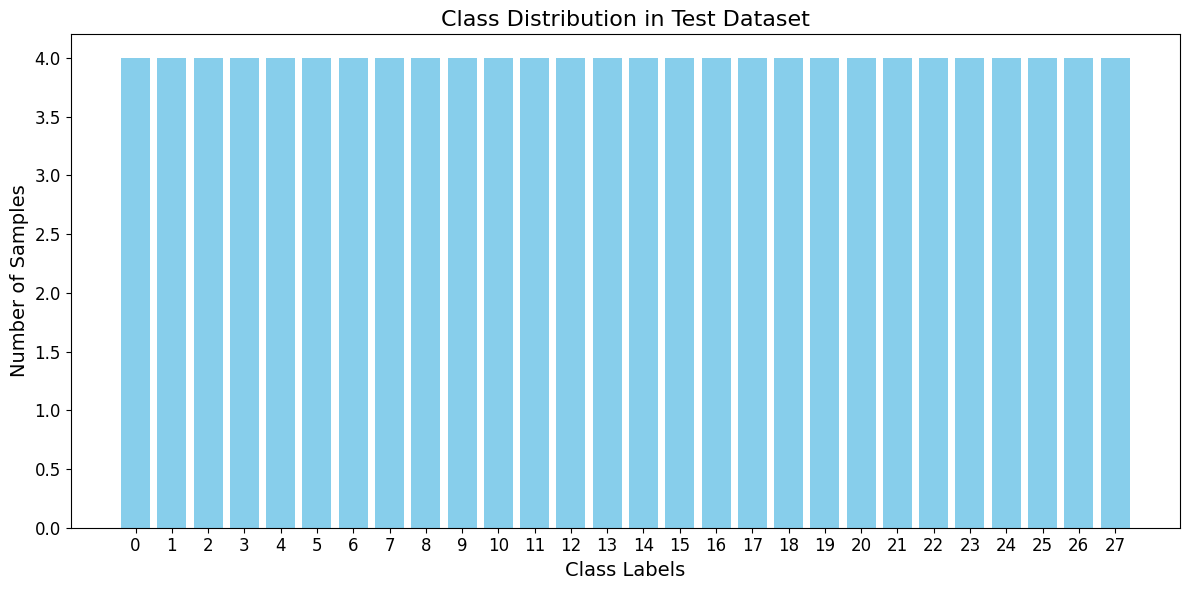

In [12]:
# Plot for test dataset
plot_class_distribution(test_dataset, "Class Distribution in Test Dataset")

### Model Training - Full Vit Training

#### Trainer Class

In [13]:
from tqdm import tqdm
import torch

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None):
        """
        Initialize the Trainer class.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())
        
        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)
            
            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau
            
            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates




In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


# ViT Tiny 

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)



# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/1


Validating: 100%|██████████| 518/518 [03:01<00:00,  2.85batch/s]

Train Loss: 0.0266, Train Accuracy: 0.9935
Validation Loss: 0.0035, Validation Accuracy: 0.9995
Learning Rate: 0.000200
Learning rates per epoch: [0.0002]
Training completed in: 2206.06 seconds


In [16]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time


# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)





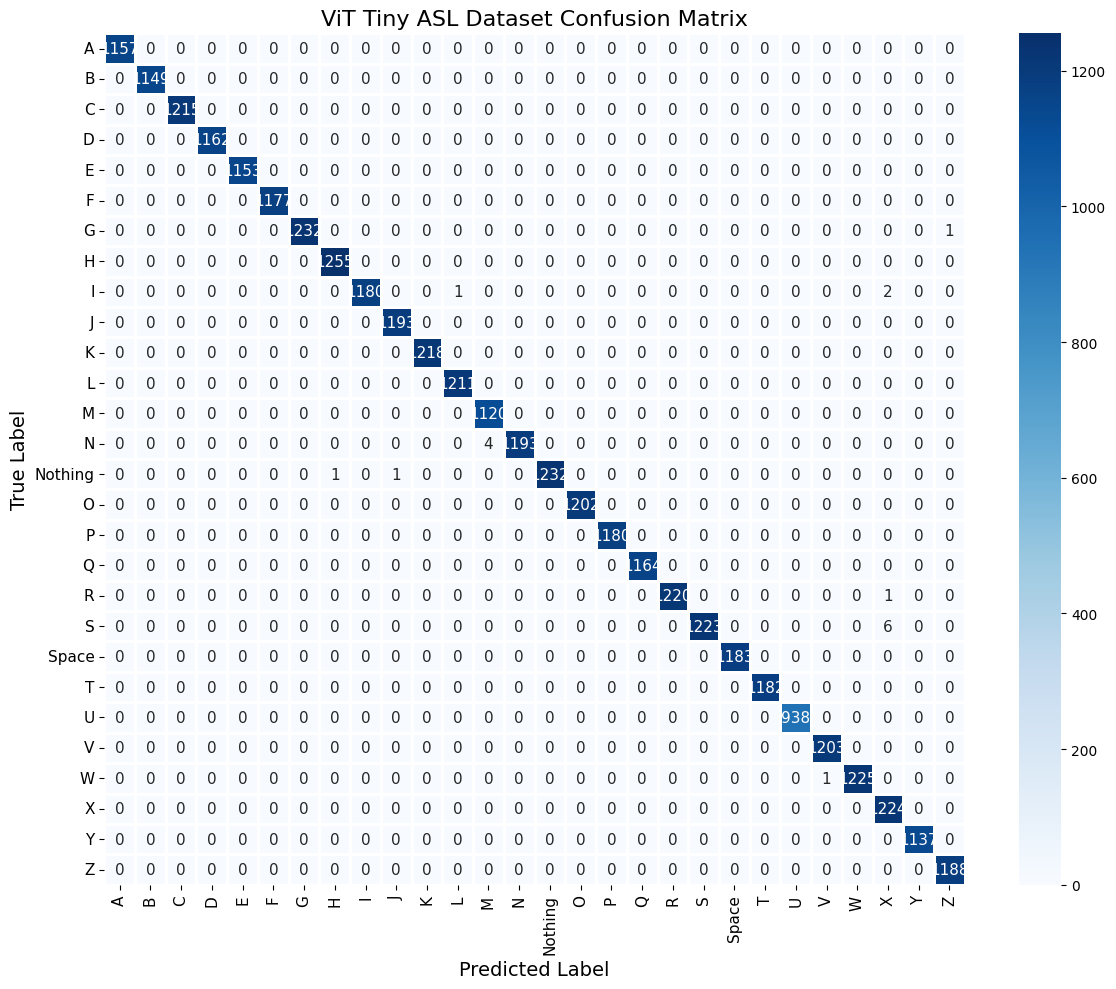

In [17]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


In [18]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:00<00:00,  3.21batch/s]

Test Loss: 0.0009, Test Accuracy: 1.0000


# ViT Tiny Classifier

In [19]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-2
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=3
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")


Epoch 1/3


Validating: 100%|██████████| 518/518 [02:56<00:00,  2.93batch/s]


Train Loss: 0.0900, Train Accuracy: 0.9864
Validation Loss: 0.0139, Validation Accuracy: 0.9982
Learning Rate: 0.001000
Epoch 2/3


Validating: 100%|██████████| 518/518 [02:58<00:00,  2.90batch/s]


Train Loss: 0.0090, Train Accuracy: 0.9985
Validation Loss: 0.0081, Validation Accuracy: 0.9985
Learning Rate: 0.001000
Epoch 3/3


Validating: 100%|██████████| 518/518 [02:56<00:00,  2.93batch/s]

Train Loss: 0.0056, Train Accuracy: 0.9989
Validation Loss: 0.0054, Validation Accuracy: 0.9988
Learning Rate: 0.001000
Learning rates per epoch: [0.001, 0.001, 0.001]
Training completed in: 2682.80 seconds


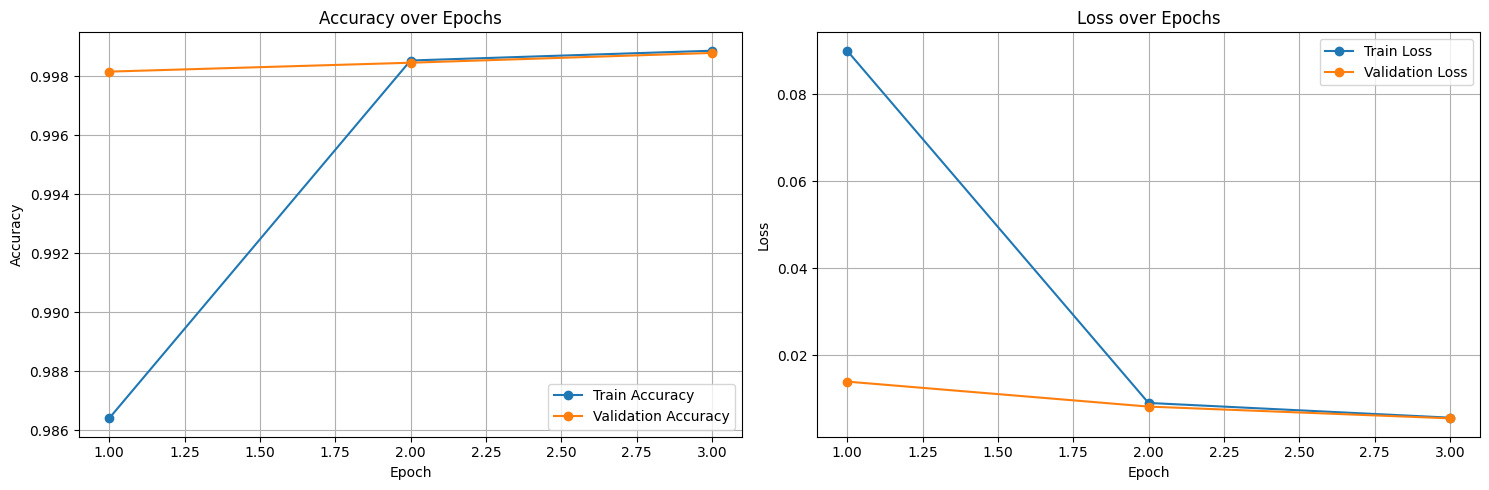

In [20]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [21]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


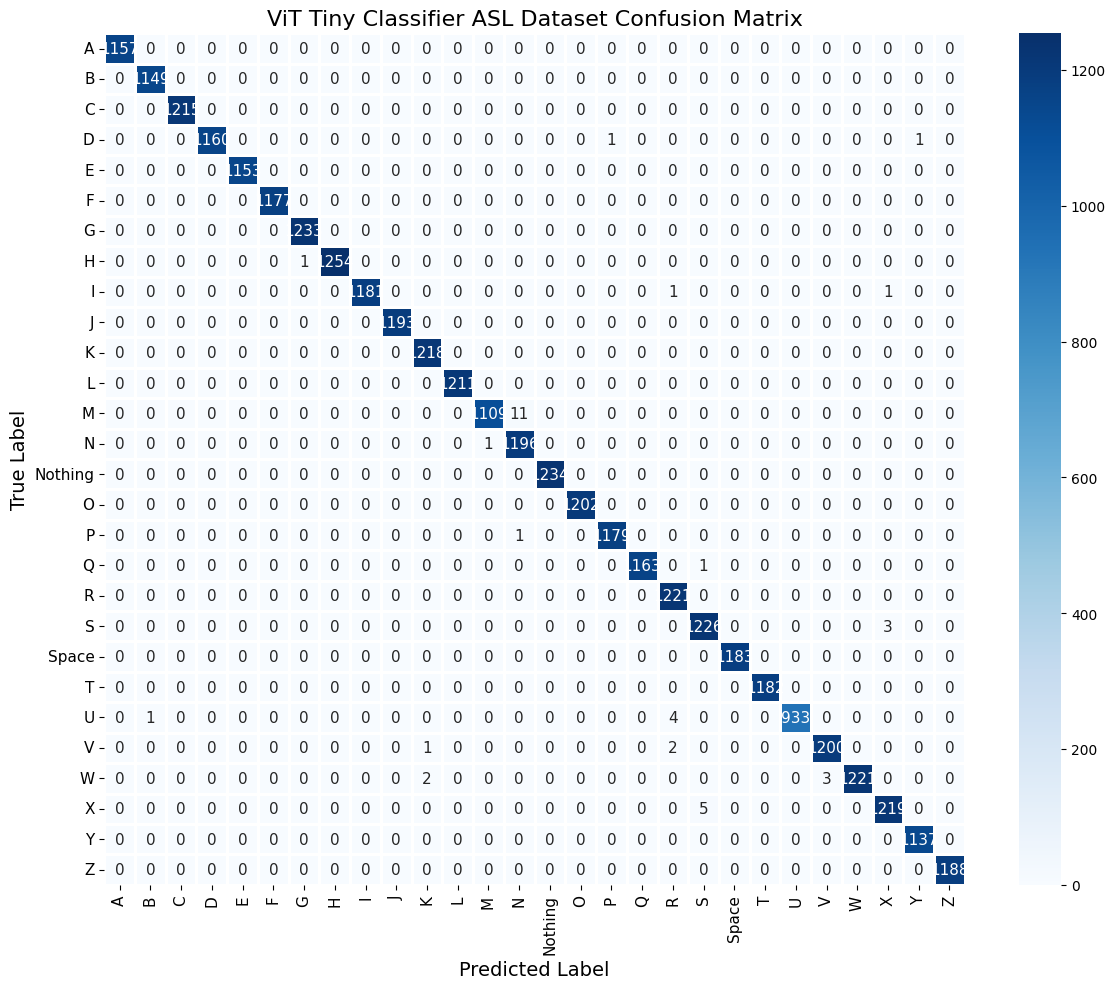

In [22]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Classifier ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [23]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)


Validating: 100%|██████████| 2/2 [00:00<00:00,  2.66batch/s]


In [24]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0022, Test Accuracy: 1.0000


# ViT Base Classifier Only

In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=5e-4, weight_decay=1e-2
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 518/518 [12:06<00:00,  1.40s/batch]


Train Loss: 0.0783, Train Accuracy: 0.9902
Validation Loss: 0.0052, Validation Accuracy: 0.9998
Learning Rate: 0.000500
Epoch 2/2


Validating: 100%|██████████| 518/518 [12:11<00:00,  1.41s/batch]

Train Loss: 0.0028, Train Accuracy: 1.0000
Validation Loss: 0.0015, Validation Accuracy: 0.9999
Learning Rate: 0.000500
Learning rates per epoch: [0.0005, 0.0005]
Training completed in: 7292.69 seconds


In [26]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

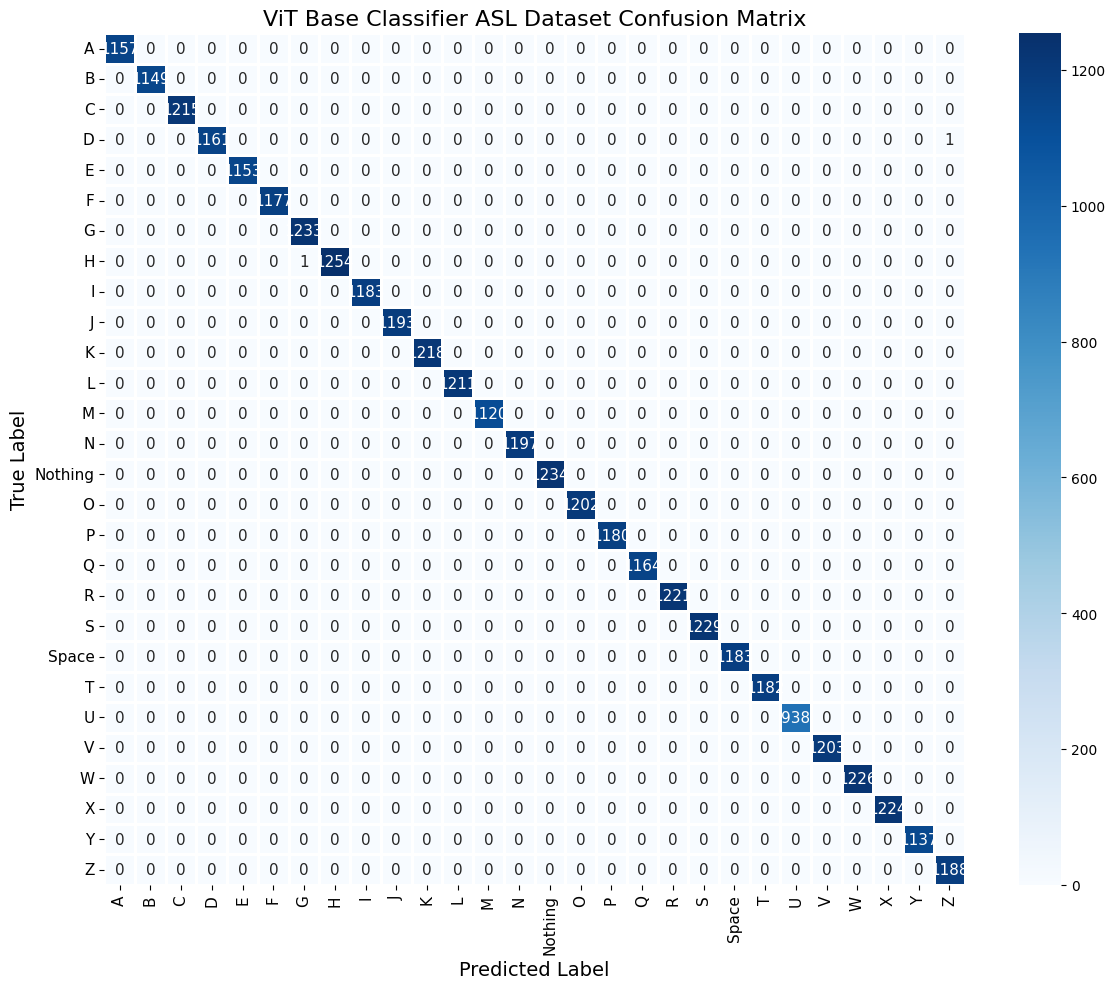

In [27]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Classifier ASL Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

In [28]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.21s/batch]

Test Loss: 0.0007, Test Accuracy: 1.0000


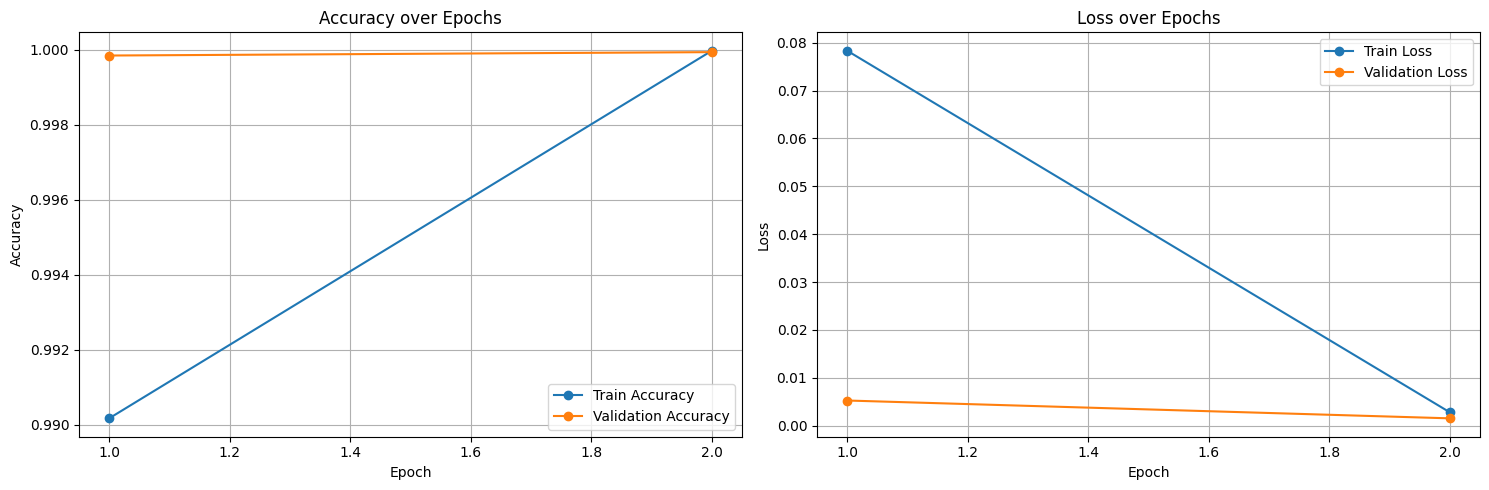

In [29]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# EfficientViT 

In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit("efficientvit_m5.r224_in1k", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 518/518 [02:05<00:00,  4.13batch/s]


Train Loss: 0.1993, Accuracy: 0.9803
Val Loss: 0.0022, Accuracy: 1.0000
Epoch 2/2


Validating: 100%|██████████| 518/518 [02:05<00:00,  4.13batch/s]

Train Loss: 0.0019, Accuracy: 0.9998
Val Loss: 0.0005, Accuracy: 1.0000
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 2099.26 seconds


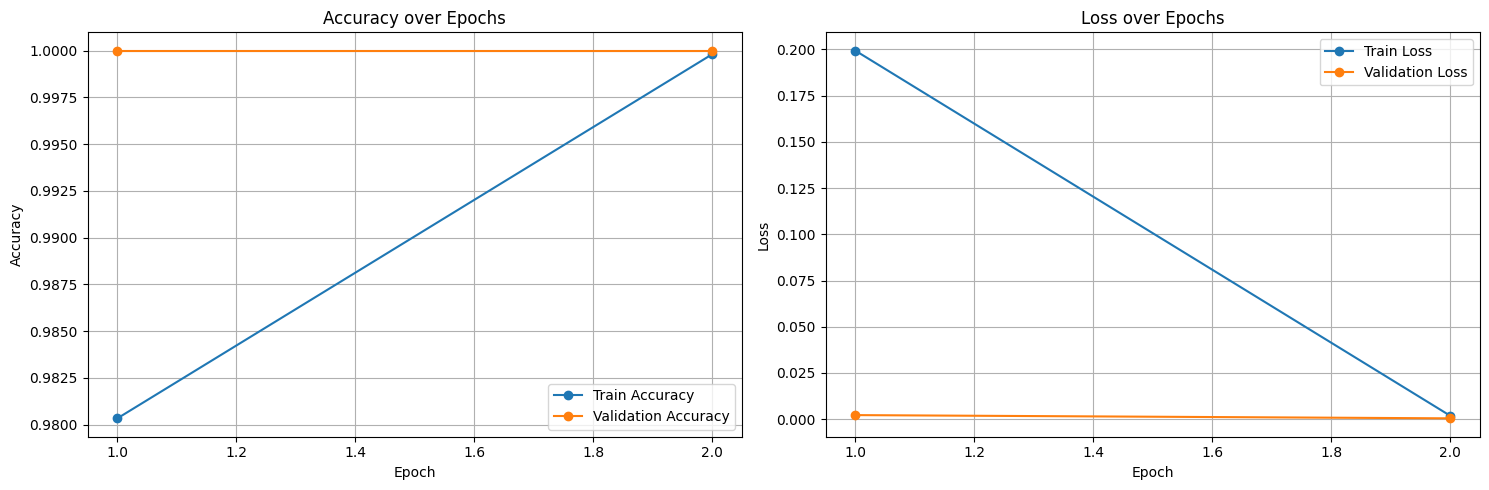

In [31]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [32]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

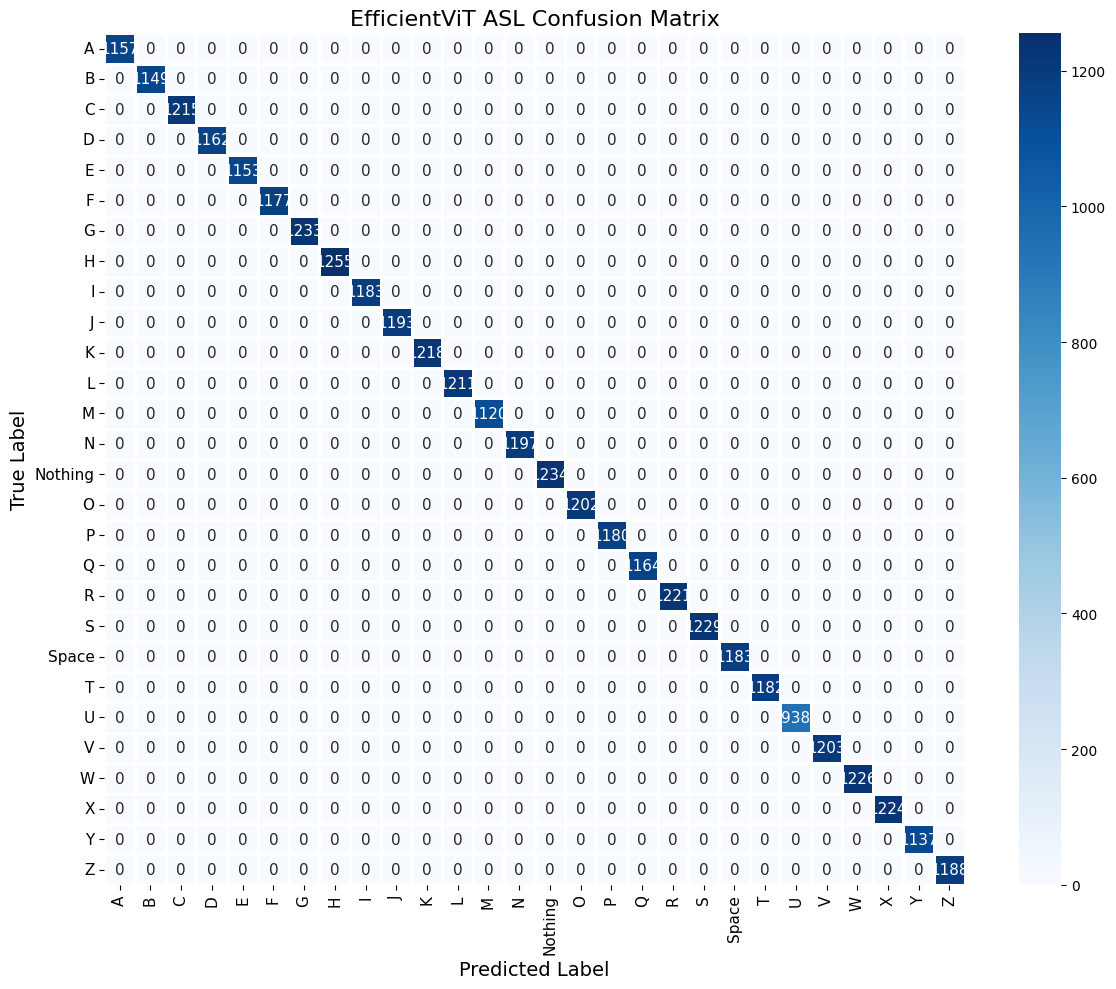

In [33]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("EfficientViT ASL Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

# DeIT-III

In [34]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from torch.optim.lr_scheduler import CosineAnnealingLR
from ViT_Trainer import Trainer, load_vit  
import time

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes=num_classes
# Load the pre-trained ViT-Tiny model using the imported function
model = load_vit("deit3_small_patch16_224.fb_in22k_ft_in1k", num_classes, device)

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the Trainer
trainer = Trainer(model, optimizer, loss_fn, device)

start_time = time.time()

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=1
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/1


Validating: 100%|██████████| 518/518 [10:01<00:00,  1.16s/batch]

Train Loss: 0.0262, Accuracy: 0.9934
Val Loss: 0.0001, Accuracy: 0.9999
Learning rates per epoch: [0.0002]
Training completed in: 11872.09 seconds


In [35]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

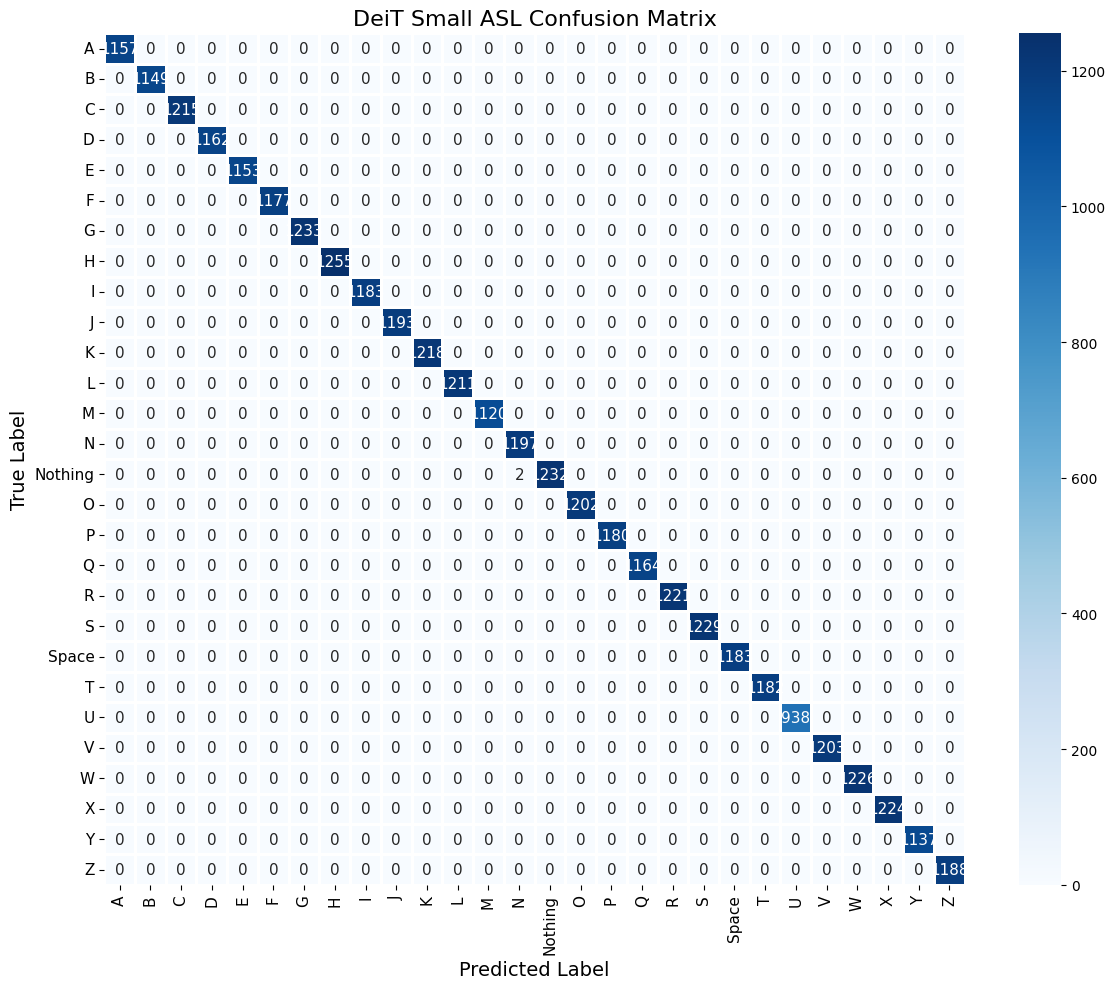

In [36]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("DeiT Small ASL Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()